In [86]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder

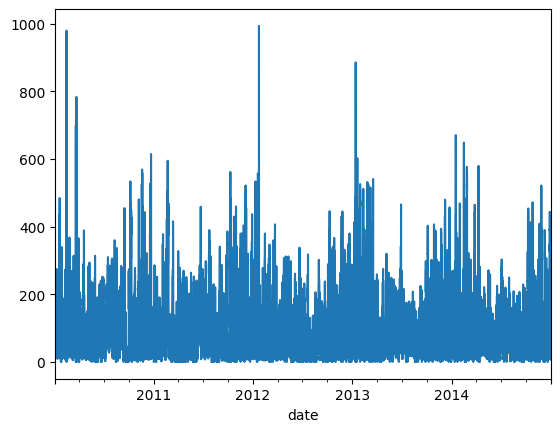

In [87]:
# Загрузка данных
df = pd.read_csv('pollution.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Преобразование категориальных данных в числовые
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

# Визуализация данных
df['pollution'].plot()
plt.show()

In [88]:
# Тест Дики-Фуллера на стационарность
result = adfuller(df['pollution'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Проверка стационарности
if result[1] < 0.05:
    print("Ряд является стационарным")
else:
    print("Ряд не является стационарным")

ADF Statistic: -21.004109
p-value: 0.000000
Ряд является стационарным


In [89]:
# VAR
model = VAR(df)
model_fit = model.fit()
lag_order = model_fit.k_ar

# Прогнозирование "шаг за шагом"
predictions = np.zeros((len(df) - lag_order, df.shape[1]))
for t in range(len(df) - lag_order):
    predictions[t] = model_fit.forecast(df.values[t:t+lag_order], steps=1)
df['VAR_prediction'] = 0
df['VAR_prediction'].iloc[lag_order:] = predictions[:, 0]

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\nickross\AppData\Local\Temp\ipykernel_2336\99344806.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VAR_prediction'].iloc[lag_order:] = predictions[:, 0]


In [90]:
# LSTM
# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
pollution_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(df)
scaled_pollution = pollution_scaler.fit_transform(df[['pollution']])

train_length = int(len(scaled_data) * 0.8)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [91]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [92]:
look_back = 1
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

In [93]:
# Архитектура LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [94]:
# Обучение
model.fit(X_train, Y_train, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
35038/35038 - 56s - loss: 9.7907e-04 - 56s/epoch - 2ms/step
Epoch 2/30
35038/35038 - 54s - loss: 8.6925e-04 - 54s/epoch - 2ms/step
Epoch 3/30
35038/35038 - 54s - loss: 8.3505e-04 - 54s/epoch - 2ms/step
Epoch 4/30
35038/35038 - 54s - loss: 8.2470e-04 - 54s/epoch - 2ms/step
Epoch 5/30
35038/35038 - 54s - loss: 8.1415e-04 - 54s/epoch - 2ms/step
Epoch 6/30
35038/35038 - 54s - loss: 8.0593e-04 - 54s/epoch - 2ms/step
Epoch 7/30
35038/35038 - 54s - loss: 7.9992e-04 - 54s/epoch - 2ms/step
Epoch 8/30
35038/35038 - 54s - loss: 7.9789e-04 - 54s/epoch - 2ms/step
Epoch 9/30
35038/35038 - 54s - loss: 7.9320e-04 - 54s/epoch - 2ms/step
Epoch 10/30
35038/35038 - 54s - loss: 7.9112e-04 - 54s/epoch - 2ms/step
Epoch 11/30
35038/35038 - 54s - loss: 7.8605e-04 - 54s/epoch - 2ms/step
Epoch 12/30
35038/35038 - 54s - loss: 7.8542e-04 - 54s/epoch - 2ms/step
Epoch 13/30
35038/35038 - 54s - loss: 7.7969e-04 - 54s/epoch - 2ms/step
Epoch 14/30
35038/35038 - 54s - loss: 7.8227e-04 - 54s/epoch - 2ms/step
E

In [95]:
# Предсказание
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

274/274 [==============================] - 0s 1ms/step


In [96]:
# Обратное преобразование для масштабирования
train_predict = pollution_scaler.inverse_transform(train_predict)
Y_train = pollution_scaler.inverse_transform([Y_train])
test_predict = pollution_scaler.inverse_transform(test_predict)
Y_test = pollution_scaler.inverse_transform([Y_test])

In [97]:
# Создание DataFrame для предсказаний LSTM
lstm_predictions = pd.DataFrame(test_predict, index=df.index[-len(test_predict):], columns=['LSTM_prediction'])

# Объединение исходных данных и предсказаний
df = pd.concat([df, lstm_predictions], axis=1)

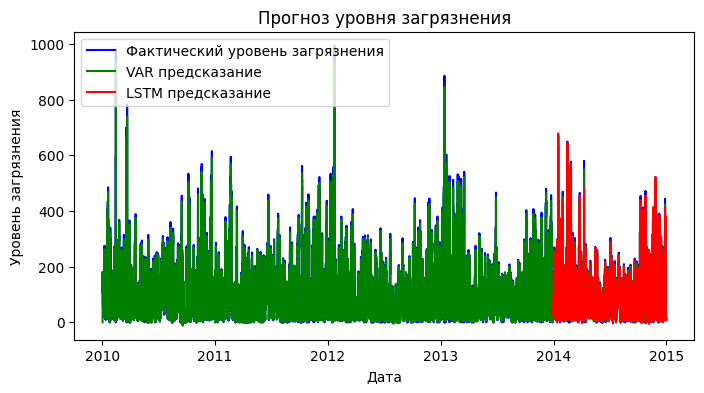

In [98]:
# Визуализация результатов
plt.figure(figsize=(8,4))
plt.plot(df['pollution'], color='blue', label='Фактический уровень загрязнения')
plt.plot(df['VAR_prediction'], color='green', label='VAR предсказание')
plt.plot(df['LSTM_prediction'], color='red', label='LSTM предсказание')
plt.title('Прогноз уровня загрязнения')
plt.xlabel('Дата')
plt.ylabel('Уровень загрязнения')
plt.legend()
plt.show()

In [100]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Метрики для VAR
var_true = df['pollution'].iloc[lag_order:].values
var_pred = df['VAR_prediction'].iloc[lag_order:].values

print('VAR Metrics:')
print('R2:', r2_score(var_true, var_pred))
print('MAE:', mean_absolute_error(var_true, var_pred))
print('RMSE:', np.sqrt(mean_squared_error(var_true, var_pred)))

# Метрики для LSTM
lstm_true = df['pollution'].iloc[-len(test_predict):].values
lstm_pred = df['LSTM_prediction'].dropna().values

print('\nLSTM Metrics:')
print('R2:', r2_score(lstm_true, lstm_pred))
print('MAE:', mean_absolute_error(lstm_true, lstm_pred))
print('RMSE:', np.sqrt(mean_squared_error(lstm_true, lstm_pred)))

VAR Metrics:
R2: 0.9138956178437914
MAE: 13.539672068162401
RMSE: 27.07004671384474

LSTM Metrics:
R2: 0.8678067556273623
MAE: 19.486612737410198
RMSE: 34.022191600322145


Результаты показывают, что обе модели - VAR и LSTM - демонстрируют хорошую производительность в прогнозировании уровня загрязнения.
1.	VAR (Векторная авторегрессия): Эта модель показала себя очень хорошо, с коэффициентом детерминации R2, равным 0.91. Это означает, что модель объясняет 91% вариации данных. Средняя абсолютная ошибка (MAE) составляет 13.54, что означает, что в среднем прогнозы модели отклоняются от истинных значений на 13.54 единиц загрязнения. Корень из среднеквадратичной ошибки (RMSE) равен 27.07, что дает нам представление о том, насколько велико отклонение прогнозов от истинных значений.
2.	LSTM (Long Short-Term Memory): Эта модель также показала хорошие результаты, хотя они немного хуже, чем у модели VAR. R2 составляет 0.87, что означает, что модель объясняет 87% вариации данных. MAE составляет 19.49, а RMSE - 34.02.
В целом, обе модели показали хорошую производительность, но VAR оказалась немного лучше LSTM в этой конкретной задаче. Предполагаю, что при более ресурсоёмком обучении модели LSTM можно было бы добиться лучшего результата, но, к сожалению, не удалось добавить GPU к процессу вычислений непосредственно под Windows, так что вычисления производились только на процессоре и занимали ощутимое время.
